This code defines a set of neural network architectures using PyTorch, primarily focused on computer vision tasks. It is divided into two distinct approaches: a modern Feature Extractor (using MobileNetV3) and legacy Pixel-Based Models (Autoencoders).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model

torch: The main PyTorch library.

torch.nn: Contains building blocks for neural networks (Layers like Conv2d, Linear).

torch.nn.functional: Contains functions that don't save state (like activation functions relu, interpolate).

timm: "PyTorch Image Models." A popular external library that provides state-of-the-art pre-trained computer vision models.

Part 2: SOTA Feature Extractor (MobileNetV3)

Viva Tip: The goal here is Patch Embedding. Instead of processing raw pixels, we want to extract rich information (features) from patches of the image using a fast, pre-trained network.

In [ ]:
def get_feature_extractor(model_name="tf_mobilenetv3_large_100", pretrained=True):

Defines a function to load the model.

model_name: Specific version of MobileNetV3 (optimized for mobile/speed).

pretrained=True: Loads weights trained on ImageNet (so the model already knows how to recognize edges, textures, and shapes).

In [ ]:
model = create_model(
        model_name,
        pretrained=pretrained,
        features_only=True,
        out_indices=[1, 2, 3] 
    )
    model.eval()

features_only=True: We strip off the final classification layer (the part that says "this is a cat"). We only want the internal feature maps.

out_indices=[1, 2, 3]: We are extracting features from layers 1, 2, and 3. This is a multi-scale approach (getting low-level details and high-level abstract shapes).

model.eval(): Sets the model to evaluation mode (freezes BatchNorm, disables Dropout).

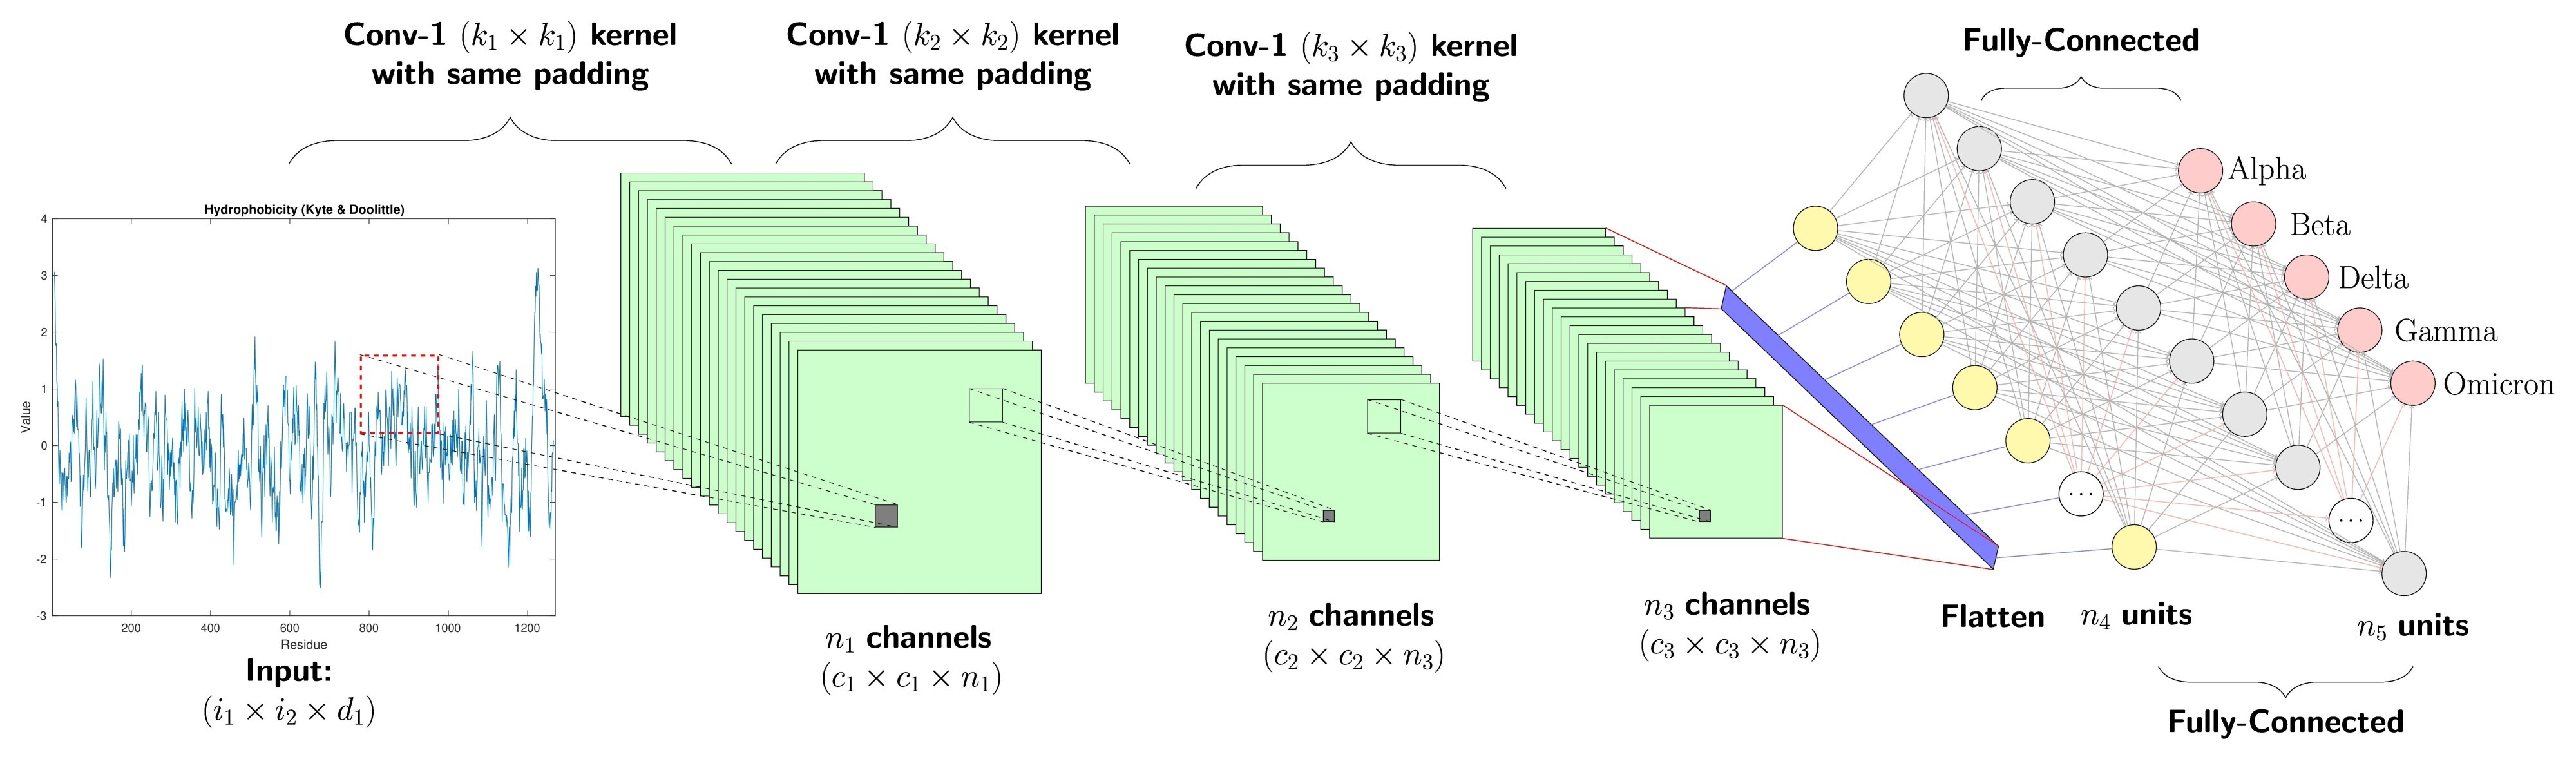

The Wrapper Class (PatchFeatureExtractor)

In [ ]:
class PatchFeatureExtractor(nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

Standard PyTorch boilerplate to wrap the MobileNet model into a class we can run.

In [ ]:
def forward(self, x):
            features = self.model(x)

Passes the image x through MobileNet.

features is a list of 3 tensors (from layers 1, 2, and 3) with different sizes.

In [ ]:
target_size = features[-1].shape[2:]

It looks at the last feature map (Layer 3). Because of pooling/striding, this will be the spatially smallest map. We use this as the target size to resize the others.

In [ ]:
resized_features = [
                F.interpolate(f, size=target_size, mode='bilinear', align_corners=False)
                for f in features
            ]

F.interpolate: This resizes the larger feature maps (from layers 1 and 2) down to the target_size.

bilinear: A standard algorithm for resizing images/features smoothly.

Why? You cannot stack tensors if they have different heights/widths.

In [ ]:
patch_features = torch.cat(resized_features, dim=1)
            return patch_features

torch.cat: Concatenates (joins) the features along the channel dimension (dim=1).

Result: A single tensor containing combined information from early and deep layers.

Part 3: Pixel-Based Models (Legacy)

Viva Tip: This section implements Autoencoders. An autoencoder compresses an image into a "latent code" and then tries to reconstruct the original image from that code.

The Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=512):
        # ... (initialization)
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)
        # ...

Conv2d arguments: (Input Channels, Output Channels, Kernel Size, Stride, Padding).

Stride=2: This is crucial. It halves the image size (Downsampling).

Input=3: RGB images.

The network goes deeper (32 -> 64 -> 128 -> 256 channels) while the image size gets smaller.

In [ ]:
self.fc = nn.Linear(256 * 16 * 16, latent_dim)

The Bottleneck: This assumes the input image is 256x256. After 4 layers of stride-2 downsampling, the size is 16x16 (256/24=16).

It flattens the 3D tensor into a flat vector of size latent_dim.

The Decoder

In [ ]:
class Decoder(nn.Module):
    # ...
    self.deconv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1)

ConvTranspose2d: Often called "deconvolution." It learns to upsample (increase image size), essentially reversing the Encoder.

In [ ]:
def forward(self, z):
        # ...
        return torch.sigmoid(self.deconv4(x))

torch.sigmoid: Squashes the output between 0 and 1.

Why? Because image pixel data is usually normalized to the [0, 1] range.

CAE (Convolutional Autoencoder)

In [ ]:
class CAE(nn.Module):
    # ...
    def forward(self, x):
        return self.decoder(self.encoder(x))

Connects Encoder directly to Decoder.

Goal: Reconstruction. It learns to compress data.

Part 4: VAE (Variational Autoencoder)

Viva Tip: This is the most complex part. Unlike the CAE, the VAE maps inputs to a probability distribution (Gaussian), not a fixed point. This allows you to generate new images.

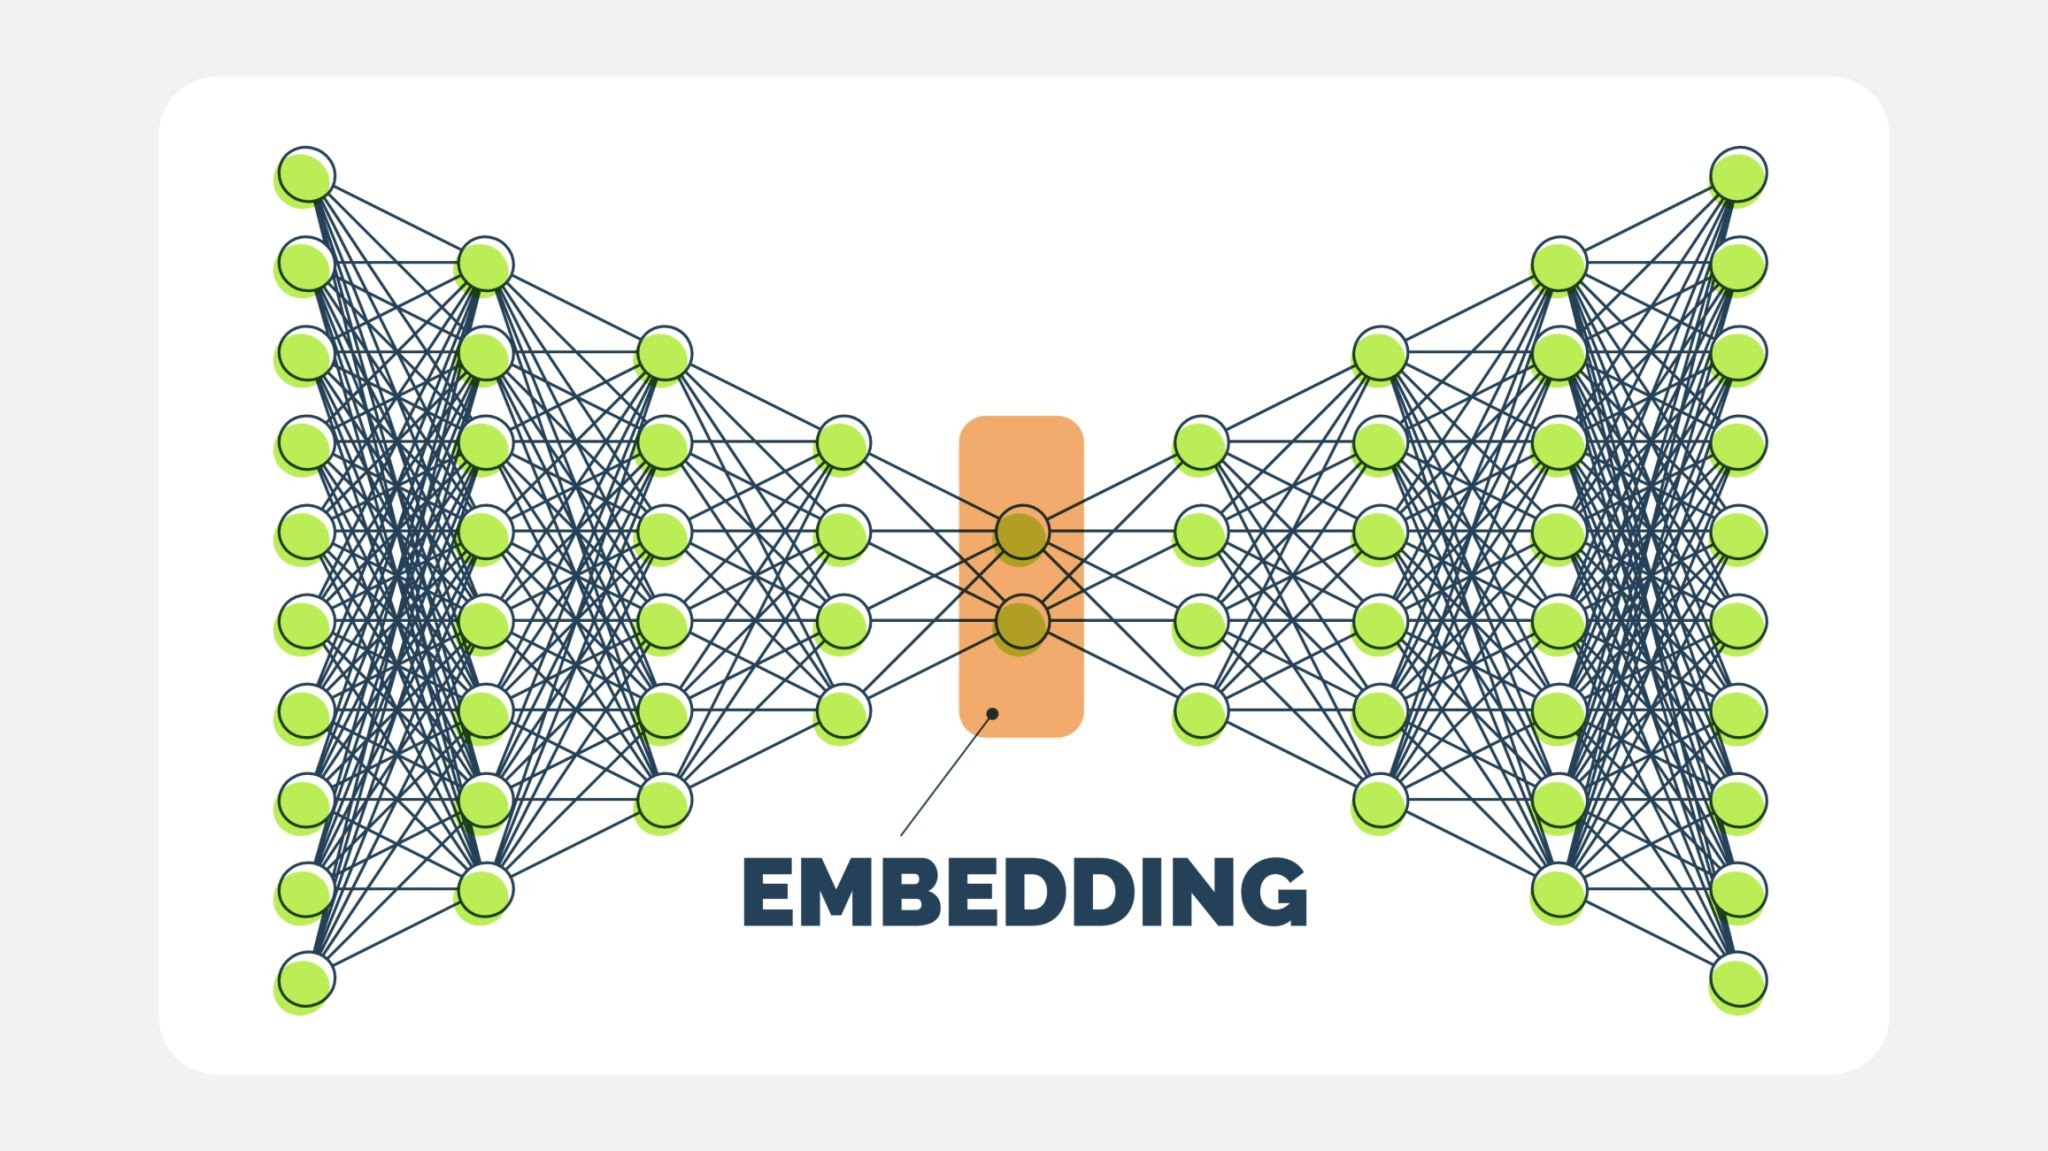

In [ ]:
class VAE(nn.Module):
    # ...
    self.fc_mu = nn.Linear(256 * 16 * 16, latent_dim)
    self.fc_logvar = nn.Linear(256 * 16 * 16, latent_dim)

Instead of one fc layer, we have two.

mu: The mean of the distribution.

logvar: The logarithm of the variance.

In [ ]:
def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

The Reparameterization Trick:

 We want to sample a random point z from the distribution defined by mu and logvar.

 Problem: We cannot backpropagate gradients through a random node.

 Solution: We move the randomness to a separate variable ϵ (torch.randn_like).

 Formula: z=μ+σ⋅ϵ (where ϵ is random noise). This allows the network to learn mu and std via backprop.

In [ ]:
def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

The VAE returns three things: the reconstructed image, the mean, and the log-variance (needed for the loss function).

Part 5: Loss Functions

In [ ]:
def cae_loss(recon, x):
    return F.l1_loss(recon, x, reduction='mean')

L1 Loss: Calculates the absolute difference between the original image x and reconstructed image recon. L1 is often preferred over L2 (MSE) in imaging because it produces less blurry images.

In [ ]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.l1_loss(recon, x, reduction='mean') 
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

Total VAE Loss = Reconstruction Loss + KL Divergence.

recon_loss: Makes sure the output looks like the input.

kl_loss (Kullback-Leibler Divergence): This measures how different our learned distribution is from a Standard Normal Distribution (Bell curve with mean 0, std 1).

  Why? It acts as a regularizer. It forces the encoder to organize the latent space smoothly, so if you sample a point near a known image, you get a similar image. Without this, the VAE would just "memorize" inputs like a normal CAE.